In [4]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow.keras as keras

import time
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, ImageDataGenerator
import os
import pydot 
import graphviz  
from keras.utils import plot_model

In [5]:
data = np.load('neutrino0523n1000000.npz')

In [6]:
data.files

['ve_dune',
 'vu_dune',
 'vebar_dune',
 'vubar_dune',
 've_t2hk',
 'vu_t2hk',
 'vebar_t2hk',
 'vubar_t2hk',
 'theta12',
 'theta13',
 'theta23',
 'delta',
 'sdm',
 'ldm',
 'octant',
 'cpv',
 'mo']

In [7]:
# Splitting 
n = 1000000

octant = data['octant'][:n]
cpv = data['cpv'][:n]
mo = data['mo'][:n]

ve_dune = data['ve_dune'][:n]
vu_dune = data['vu_dune'][:n]
vebar_dune = data['vebar_dune'][:n]
vubar_dune = data['vubar_dune'][:n]

ve_t2hk = data['ve_t2hk'][:n]
vu_t2hk = data['vu_t2hk'][:n]
vebar_t2hk = data['vebar_t2hk'][:n]
vubar_t2hk = data['vubar_t2hk'][:n]

###分成train / validation / test
ve_dune_train = ve_dune[:int(0.8*n)] 
ve_dune_test = ve_dune[int(0.8*n):int(0.9*n)] 
ve_dune_valid = ve_dune[int(0.9*n):int(n)] 

vu_dune_train = ve_dune[:int(0.8*n)] 
vu_dune_test = vu_dune[int(0.8*n):int(0.9*n)] 
vu_dune_valid = vu_dune[int(0.9*n):int(n)] 

vebar_dune_train = vebar_dune[:int(0.8*n)] 
vebar_dune_test = vebar_dune[int(0.8*n):int(0.9*n)] 
vebar_dune_valid = vebar_dune[int(0.9*n):int(n)] 

vubar_dune_train = vubar_dune[:int(0.8*n)] 
vubar_dune_test = vubar_dune[int(0.8*n):int(0.9*n)] 
vubar_dune_valid = vubar_dune[int(0.9*n):int(n)] 

ve_t2hk_train = ve_t2hk[:int(0.8*n)] 
ve_t2hk_test = ve_t2hk[int(0.8*n):int(0.9*n)] 
ve_t2hk_valid = ve_t2hk[int(0.9*n):int(n)] 

vu_t2hk_train = ve_t2hk[:int(0.8*n)] 
vu_t2hk_test = vu_t2hk[int(0.8*n):int(0.9*n)] 
vu_t2hk_valid = vu_t2hk[int(0.9*n):int(n)] 

vebar_t2hk_train = vebar_t2hk[:int(0.8*n)] 
vebar_t2hk_test = vebar_t2hk[int(0.8*n):int(0.9*n)] 
vebar_t2hk_valid = vebar_t2hk[int(0.9*n):int(n)] 

vubar_t2hk_train = vubar_t2hk[:int(0.8*n)] 
vubar_t2hk_test = vubar_t2hk[int(0.8*n):int(0.9*n)] 
vubar_t2hk_valid = vubar_t2hk[int(0.9*n):int(n)] 
####

# ###合併所有Label
# octant_s = np.array_split(octant, len(octant))
# cpv_s = np.array_split(cpv, len(cpv))
# mo_s = np.array_split(mo, len(mo))
# label_train = np.hstack((octant_s,cpv_s,mo_s))[:int(0.8*n)] 
# label_test = np.hstack((octant_s,cpv_s,mo_s))[int(0.8*n):int(0.9*n)] 
# label_valid = np.hstack((octant_s,cpv_s,mo_s))[int(0.9*n):int(n)] 


In [8]:
#將Label轉成 one-hot

octantO=[]
for i in range(n):
    if octant[i]==-1:
        octantO.append(0)
    else:
        octantO.append(1)

moO=[]
for i in range(n):
    if mo[i]==-1:
        moO.append(0)
    else:
        moO.append(1)

label_count=[]
for i in range(n):
    label_count.append(4*octantO[i]+5*cpv[i]+2*moO[i])

label_eight=[]
for i in range(n):
    if label_count[i]==11:
        label_eight.append(0) #Class 1  (octant,cpv,mo)=(1,1,1)
    if label_count[i]==6:
        label_eight.append(1) #Class 2  (octant,cpv,mo)=(1,0,1)
    if label_count[i]==7:
        label_eight.append(2) #Class 3  (octant,cpv,mo)=(-1,1,1)
    if label_count[i]==2:
        label_eight.append(3) #Class 4  (octant,cpv,mo)=(-1,0,1)
    if label_count[i]==9:
        label_eight.append(4) #Class 5  (octant,cpv,mo)=(1,1,-1)
    if label_count[i]==4:
        label_eight.append(5) #Class 6  (octant,cpv,mo)=(1,0,-1)
    if label_count[i]==5:
        label_eight.append(6) #Class 7  (octant,cpv,mo)=(-1,1,-1)    
    if label_count[i]==0:
        label_eight.append(7) #Class 8  (octant,cpv,mo)=(-1,0,-1)
label_onehot = to_categorical(label_eight,8)
label_train = label_onehot[:int(0.8*n)] 
label_test = label_onehot[int(0.8*n):int(0.9*n)] 
label_valid = label_onehot[int(0.9*n):int(n)] 

In [9]:
label_eight[:10]

[3, 2, 3, 1, 7, 3, 7, 1, 6, 0]

In [10]:
label_train[:10]

array([[0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
input_ve_dune=keras.Input(shape=(50,),name="input_ve_dune")
input_vebar_dune=keras.Input(shape=(50,),name="input_vebar_dune")
input_ve_t2hk=keras.Input(shape=(11,),name="input_ve_t2hk")
input_vebar_t2hk=keras.Input(shape=(11,),name="input_vebar_t2hk")

concat_dune=layers.Concatenate(name="concat_dune")([input_ve_dune, input_vebar_dune])
concat_t2hk=layers.Concatenate(name="concat_t2hk")([input_ve_t2hk,input_vebar_t2hk])

dense_dune1 =layers.Dense(256,name="dense_dune1", activation='softmax')(concat_dune)
dense_t2hk1 =layers.Dense(256,name="dense_t2hk2", activation='softmax')(concat_t2hk)

concat_all=layers.Concatenate(name="concat_all")([dense_dune1,dense_t2hk1])

label =layers.Dense(128,name="label", activation='softmax')(concat_all)

output_label =layers.Dense(8, activation='softmax',name="output_label")(label) #sigmoid比relu效果好

model_api=keras.Model(inputs=[input_ve_dune,input_vebar_dune,input_ve_t2hk, input_vebar_t2hk], outputs=[output_label],name="API_Model")
model_api.compile(loss='categorical_crossentropy',
           optimizer="adam",
            metrics=('accuracy'))
model_api.summary()

Model: "API_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ve_dune (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_vebar_dune (InputLayer)   [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ve_t2hk (InputLayer)      [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_vebar_t2hk (InputLayer)   [(None, 11)]         0                                            
__________________________________________________________________________________________

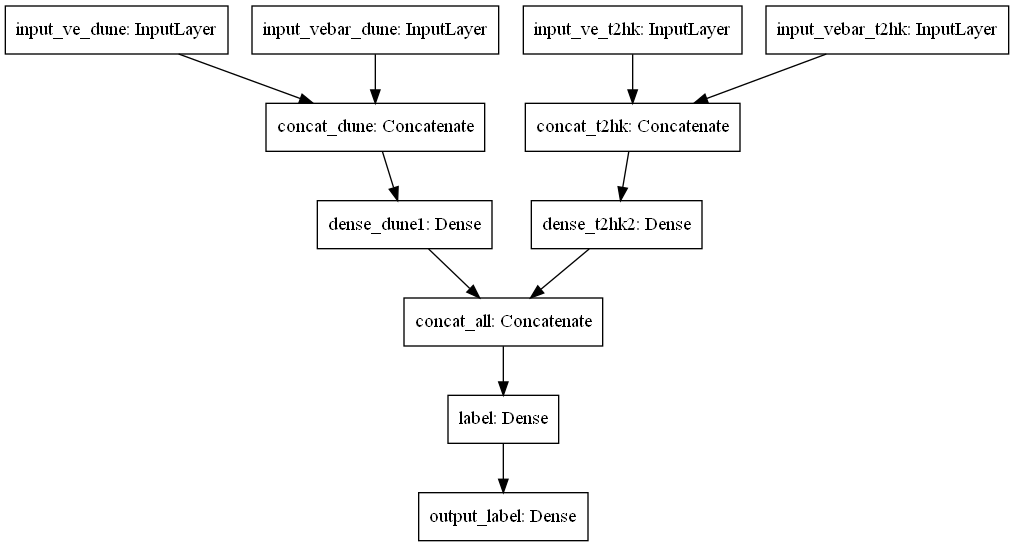

In [12]:
keras.utils.plot_model(model_api, "model_api.png")

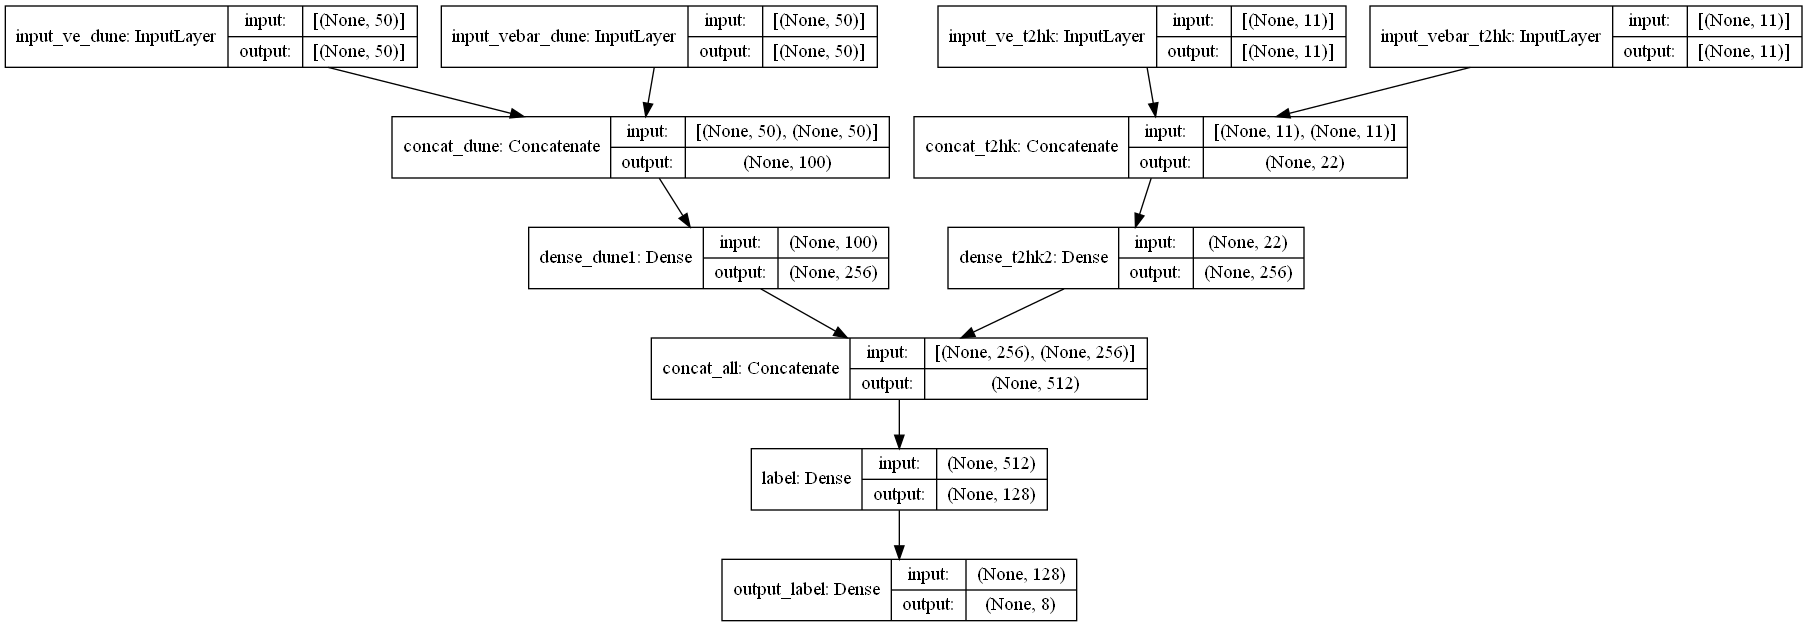

In [13]:
keras.utils.plot_model(model_api, "model_api_with_shape_info.png", show_shapes=True)

In [14]:
batch_size = 512
nb_train_samples = len(ve_dune_train)
nb_valid_samples = len(ve_dune_valid)
nb_test_samples = len(ve_dune_test)

In [15]:
def generator_train():
    while True:
        for start in range(0, nb_train_samples, batch_size):
            x1_batch = []
            x2_batch = []
            x3_batch = []
            x4_batch = []
            
            y_batch = []               
            
            end = min(start + batch_size, nb_train_samples)
            for i in range(start, end):
                x1_batch.append(ve_dune_train[i]/np.max(ve_dune_train[i]))
                x2_batch.append(vebar_dune_train[i]/np.max(vebar_dune_train[i]))
                x3_batch.append(ve_t2hk_train[i]/np.max(ve_t2hk_train[i]))
                x4_batch.append(vebar_t2hk_train[i]/np.max(vebar_t2hk_train[i]))
                
                y_batch.append(label_train[i])   
    
            yield ({'input_ve_dune':np.array(x1_batch),'input_vebar_dune':np.array(x2_batch),'input_ve_t2hk':np.array(x3_batch),'input_vebar_t2hk': np.array(x4_batch)},
                   {'output_label':np.array(y_batch)})

In [16]:
def generator_valid():
    while True:
        for start in range(0, nb_valid_samples, batch_size):
            x1_batch = []
            x2_batch = []
            x3_batch = []
            x4_batch = []
            
            y_batch = []    
            
            end = min(start + batch_size, nb_valid_samples)
            for i in range(start, end):
                x1_batch.append(ve_dune_valid[i]/np.max(ve_dune_valid[i]))
                x2_batch.append(vebar_dune_valid[i]/np.max(vebar_dune_valid[i]))
                x3_batch.append(ve_t2hk_valid[i]/np.max(ve_t2hk_valid[i]))
                x4_batch.append(vebar_t2hk_valid[i]/np.max(vebar_t2hk_valid[i]))
                
                y_batch.append(label_valid[i])   
    
            yield ({'input_ve_dune':np.array(x1_batch),'input_vebar_dune':np.array(x2_batch),'input_ve_t2hk':np.array(x3_batch),'input_vebar_t2hk': np.array(x4_batch)},
                   {'output_label':np.array(y_batch)})

In [17]:
def generator_test():
    while True:
        for start in range(0, nb_test_samples, batch_size):
            x1_batch = []
            x2_batch = []
            x3_batch = []
            x4_batch = []
            
            y_batch = []                       
            end = min(start + batch_size, nb_test_samples)
            for i in range(start, end):
                x1_batch.append(ve_dune_test[i]/np.max(ve_dune_test[i]))
                x2_batch.append(vebar_dune_test[i]/np.max(vebar_dune_test[i]))
                x3_batch.append(ve_t2hk_test[i]/np.max(ve_t2hk_test[i]))
                x4_batch.append(vebar_t2hk_test[i]/np.max(vebar_t2hk_test[i]))
                
                y_batch.append(label_test[i])   
    
            yield ({'input_ve_dune':np.array(x1_batch),'input_vebar_dune':np.array(x2_batch),'input_ve_t2hk':np.array(x3_batch),'input_vebar_t2hk': np.array(x4_batch)},
                   {'output_label':np.array(y_batch)})

In [18]:
epochs = 100

In [19]:
History = model_api.fit_generator(
    generator_train(),
    epochs= epochs,
    steps_per_epoch= nb_train_samples // batch_size,
    validation_data= generator_valid(),
    validation_steps = nb_valid_samples//batch_size,
    shuffle = True
)

C:\Users\Cheng-Li\Documents\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1562/1562 [==============================] - 29s 18ms/step - loss: 1.6682 - accuracy: 0.2351 - val_loss: 1.4158 - val_accuracy: 0.2513
Epoch 2/100
1562/1562 [==============================] - 28s 18ms/step - loss: 1.3993 - accuracy: 0.2510 - val_loss: 1.3926 - val_accuracy: 0.2509
Epoch 3/100
1562/1562 [==============================] - 27s 17ms/step - loss: 1.3906 - accuracy: 0.2506 - val_loss: 1.3891 - val_accuracy: 0.2509
Epoch 4/100
1562/1562 [==============================] - 27s 18ms/step - loss: 1.3883 - accuracy: 0.2512 - val_loss: 1.3877 - val_accuracy: 0.2509
Epoch 5/100
1562/1562 [==============================] - 27s 17ms/step - loss: 1.3874 - accuracy: 0.2514 - val_loss: 1.3870 - val_accuracy: 0.2510
Epoch 6/100
1562/1562 [==============================] - 27s 17ms/step - loss: 1.3868 - accuracy: 0.2522 - val_loss: 1.3866 - val_accuracy: 0.2516
Epoch 7/100
1562/1562 [==============================] - 27s 17ms/step - loss: 1.3137 - accuracy: 0.3612 - val_loss: 1

In [50]:
model_api.save_weights("model_api.h5")

In [139]:
# Evaluating the model
scores = model_api.evaluate_generator(generator=generator_test(), steps=nb_test_samples // batch_size)
print("Test 8-Classes accuracy is {}".format(scores[1]))

Test 8-Classes accuracy is 0.7970252633094788


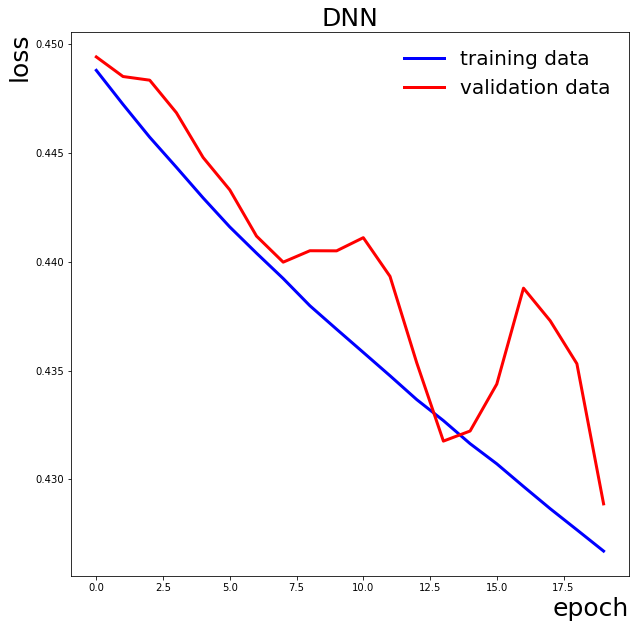

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(History.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History.history["val_loss"], label='validation data',c='red',linewidth = 3)

plt.title("DNN", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

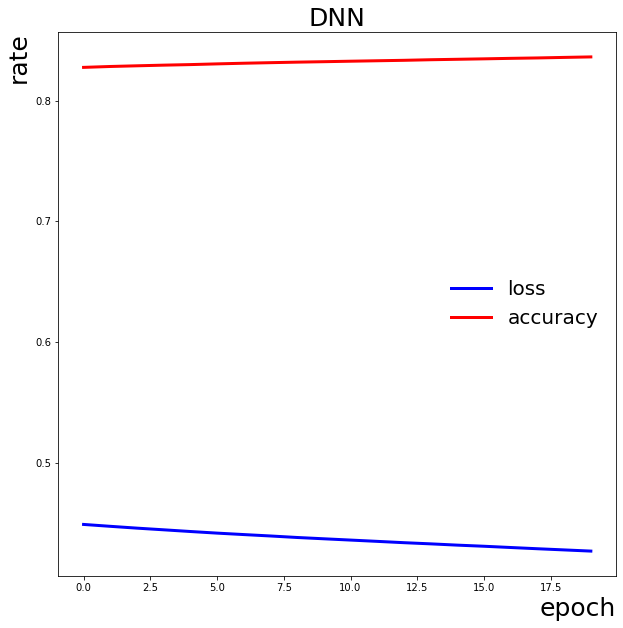

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(History.history["loss"], label='loss',c='blue',linewidth = 3)
plt.plot(History.history["accuracy"], label='accuracy',c='red',linewidth = 3)

plt.title("DNN", fontsize=25)

ax.set_ylabel('rate', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

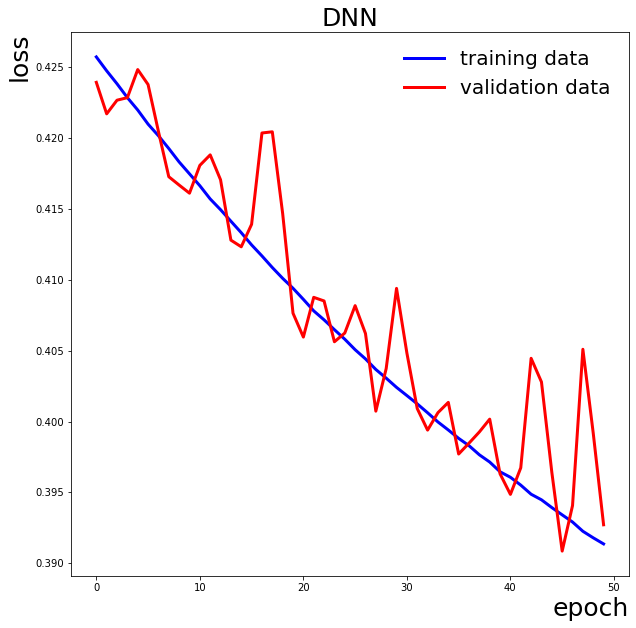

In [51]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(History.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History.history["val_loss"], label='validation data',c='red',linewidth = 3)

plt.title("DNN", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

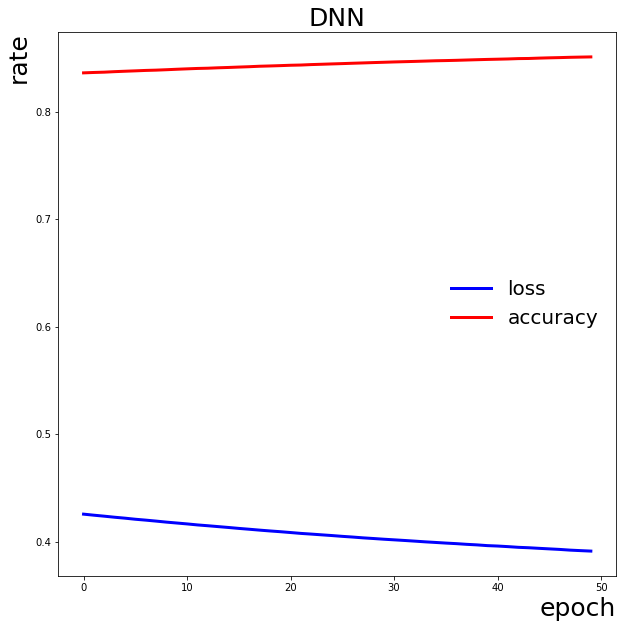

In [52]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(History.history["loss"], label='loss',c='blue',linewidth = 3)
plt.plot(History.history["accuracy"], label='accuracy',c='red',linewidth = 3)

plt.title("DNN", fontsize=25)

ax.set_ylabel('rate', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

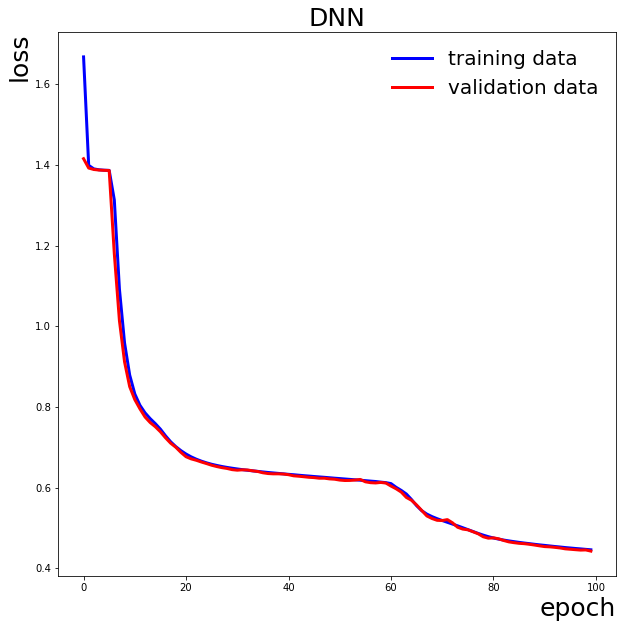

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(History.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History.history["val_loss"], label='validation data',c='red',linewidth = 3)

plt.title("DNN", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

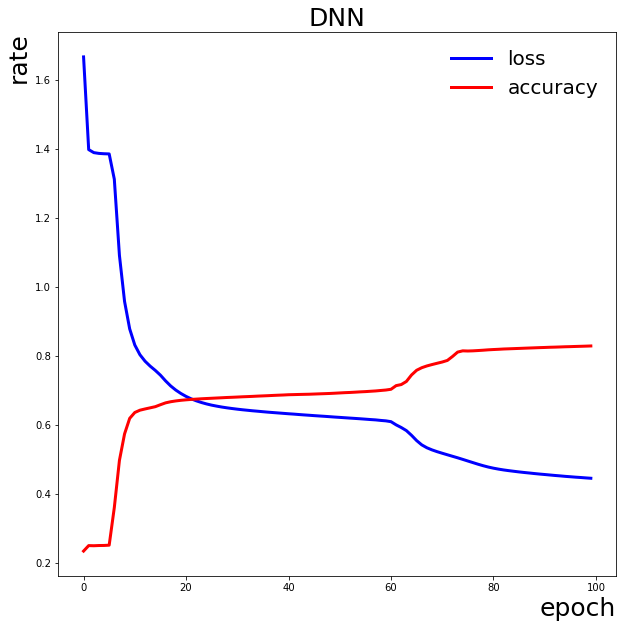

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(History.history["loss"], label='loss',c='blue',linewidth = 3)
plt.plot(History.history["accuracy"], label='accuracy',c='red',linewidth = 3)

plt.title("DNN", fontsize=25)

ax.set_ylabel('rate', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

In [46]:
History.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [143]:
label_train[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [30]:
prediction_train = model_api.predict_generator([ve_dune_train,vebar_dune_train,ve_t2hk_train,vebar_t2hk_train])

In [31]:
prediction_train[:50]

array([[9.9797803e-01, 1.8914918e-03, 1.2998309e-04, 4.4608245e-07,
        8.1273444e-10, 1.6483632e-14, 1.0692866e-07, 2.9651330e-14],
       [9.9797803e-01, 1.8914918e-03, 1.2998309e-04, 4.4608245e-07,
        8.1273444e-10, 1.6483632e-14, 1.0692866e-07, 2.9651330e-14],
       [9.9797803e-01, 1.8914918e-03, 1.2998309e-04, 4.4608245e-07,
        8.1273444e-10, 1.6483632e-14, 1.0692866e-07, 2.9651330e-14],
       [9.9797803e-01, 1.8914918e-03, 1.2998309e-04, 4.4608245e-07,
        8.1273444e-10, 1.6483632e-14, 1.0692866e-07, 2.9651330e-14],
       [9.9797803e-01, 1.8914918e-03, 1.2998309e-04, 4.4608245e-07,
        8.1273444e-10, 1.6483632e-14, 1.0692866e-07, 2.9651330e-14],
       [9.9797803e-01, 1.8914918e-03, 1.2998309e-04, 4.4608245e-07,
        8.1273444e-10, 1.6483632e-14, 1.0692866e-07, 2.9651330e-14],
       [9.9797803e-01, 1.8914918e-03, 1.2998309e-04, 4.4608245e-07,
        8.1273444e-10, 1.6483632e-14, 1.0692866e-07, 2.9651330e-14],
       [9.9797803e-01, 1.8914918e-03, 1.2

In [28]:
prediction_test = model_api.predict([ve_dune_test,vebar_dune_test,ve_t2hk_test,vebar_t2hk_test])
prediction_test = np.argmax(prediction_test,axis=1)

In [29]:
prediction_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [64]:
auc_train

NameError: name 'auc_train' is not defined

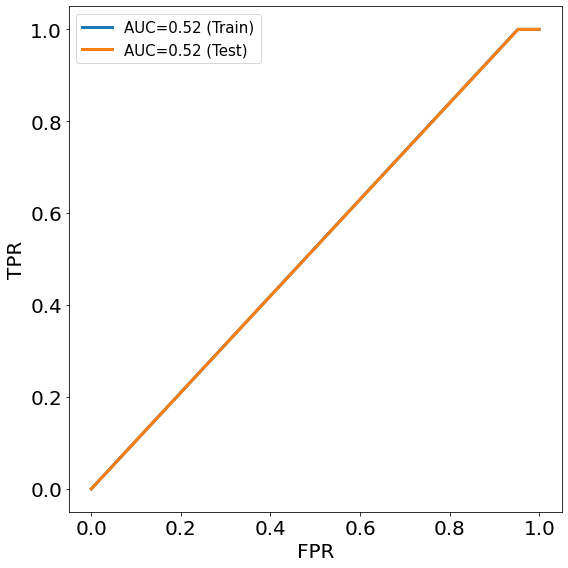

In [78]:
"""
Define axis for ROC
"""  
axis = 0
if axis == 0:
    Class = "W/Z jets"
    other = "Quark jets"
elif axis == 1:
    Class = "Quark jets"
    other = "W/Z jets"

"""
Calculate AUC
"""

auc_train = metrics.roc_auc_score(label_train[:,axis],prediction_train[:,axis])
auc_test = metrics.roc_auc_score(label_test[:,axis],prediction_test[:,axis])


"""
Calculate FPR and TPR
"""
FalsePositive_train, TruePositive_train, _ = metrics.roc_curve(label_train[:,axis],prediction_train[:,axis])
FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(label_test[:,axis],prediction_test[:,axis])


"""
Generate ROC figure
"""
fig, ax = plt.subplots(1,1, figsize=(8,8))


plt.plot(FalsePositive_train, TruePositive_train,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Train)'.format(auc_train))
plt.plot(FalsePositive_test, TruePositive_test,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()


